In [1]:
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
from os import path

from deployment_instance import ExperimentResult
from src.ingest_data import ingest_experiment_results
from src.query_data import get_data_exfiltration_times, get_data_exfiltration_cdf
from statistics import mean
import seaborn as sns
# set seaborn font size
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

import pandas as pd

In [13]:
# Non reactive
baseline_standalone_d0_h50 = ingest_experiment_results(path.join('data/Standalone/EquifaxLarge/baseline_standalone_d0_h50'))
baseline_standalone_d10_h0 = ingest_experiment_results(path.join('data/Standalone/EquifaxLarge/baseline_standalone_d10_h0'))
baseline_layered_d10_h50 = ingest_experiment_results(path.join('data/Layered/EquifaxLarge/baseline_layered_d10_h50'))

# Reactive
baseline_reactiveStandalone_d0_h50 = ingest_experiment_results(path.join('data/Reactive/EquifaxLarge/baseline_reactiveStandalone_d0_h50'))
baseline_reactiveStandalone_d10_h0 = ingest_experiment_results(path.join('data/Reactive/EquifaxLarge/baseline_reactiveStandalone_d10_h0'))
baseline_reactiveLayered_d10_h50 = ingest_experiment_results(path.join('data/Reactive/EquifaxLarge/baseline_reactiveLayered_d10_h50'))

all_data = {}
all_data.update(baseline_standalone_d0_h50)
all_data.update(baseline_standalone_d10_h0)
all_data.update(baseline_layered_d10_h50)
all_data.update(baseline_reactiveStandalone_d0_h50)
all_data.update(baseline_reactiveStandalone_d10_h0)
all_data.update(baseline_reactiveLayered_d10_h50)

In [16]:
def get_number_files_exfiltrated(data: dict[str, ExperimentResult], expected_files: int):
    df = pd.DataFrame(
        columns=[
            "experiment_type",
            "id",
            "files_exfiltrated",
        ]
    )

    for experiment_num, experiment_result in data.items():
        files_exfiltrated = len(experiment_result.data_exfiltrated)
        df.loc[df.shape[0]] = [
            experiment_result.scenario.name,
            experiment_num,
            files_exfiltrated,
        ]

    return df

test_df = get_number_files_exfiltrated(all_data, 48)

In [4]:
def convert_data_to_df(data: dict[str, ExperimentResult], experiment: str, num_expected_files):
    df = pd.DataFrame(
        columns=[
            "experiment",
            "type",
            "name",
            "experiment_num",
            "time_exfiltrated",
            "file_number",
            "percent_data",
        ]
    )

    for experiment_num, experiment_result in enumerate(list(data.values())):
        for idx, data_exfiltrated in enumerate(experiment_result.data_exfiltrated):
            if 'reactive' in experiment_result.scenario.name:
                exp_type = 'reactive'
            else:
                exp_type = 'non-reactive'

            df.loc[df.shape[0]] = [
                experiment,
                exp_type,
                experiment_result.scenario.name,
                experiment_num,
                data_exfiltrated.time_exfiltrated / 60,
                idx + 1,
                ((idx + 1) / num_expected_files) * 100,
            ]

    return df

In [5]:
# merge dicts
standalone_d10_h0 = {}
standalone_d10_h0.update(baseline_standalone_d10_h0)
standalone_d10_h0.update(baseline_reactiveStandalone_d10_h0)
standalone_d10_h0_df = convert_data_to_df(standalone_d10_h0, 'standalone_d10_h0', 48)

standalone_d0_h50 = {}
standalone_d0_h50.update(baseline_standalone_d0_h50)
standalone_d0_h50.update(baseline_reactiveStandalone_d0_h50)
standalone_d0_h50_df = convert_data_to_df(standalone_d0_h50, 'standalone_d0_h50', 48)

layered_d10_h50 = {}
layered_d10_h50.update(baseline_layered_d10_h50)
layered_d10_h50.update(baseline_reactiveLayered_d10_h50)
layered_d0_h50_df = convert_data_to_df(layered_d10_h50, 'layered_d0_h50', 48)

data = df_appended = pd.concat([standalone_d10_h0_df, standalone_d0_h50_df, layered_d0_h50_df], ignore_index=True)

/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/brian/miniconda3/envs/openstack/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

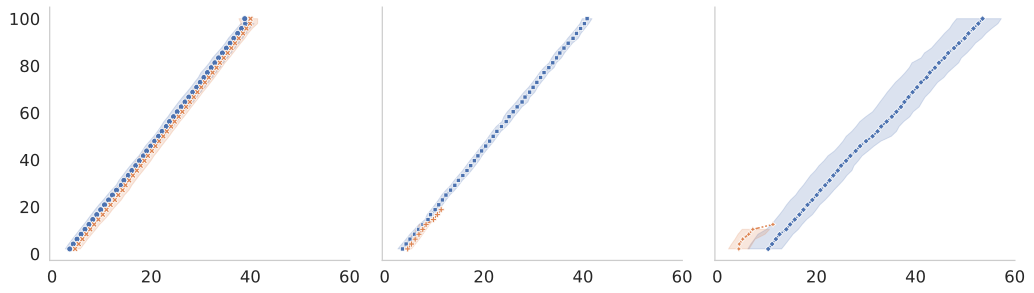

In [6]:
# ax = sns.relplot(data=standalone_d10_h0_df, 
#              x="time_exfiltrated", y="percent_data", hue="name", col='experiment',
#              markers=True, dashes=True, legend=False, orient="y")
g = sns.relplot(
    data=data,
    x="time_exfiltrated", y="percent_data", orient="y", col="experiment", hue="type",
    style="name", markers=True, dashes=True, legend=False,
    kind="line", 
)

# Remove x-axis label
g.set_axis_labels("", "")
g.set_titles("")

# # Save as svg
g.savefig('./plots/reactive.svg', transparent=True)
# plt = ax.get_figure()
# plt.savefig('./plots/reactive_d10_h0.svg', transparent=True)